In [2]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [5]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [26]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])

# Apply augmentation to the training data
def augment(image, label):
    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



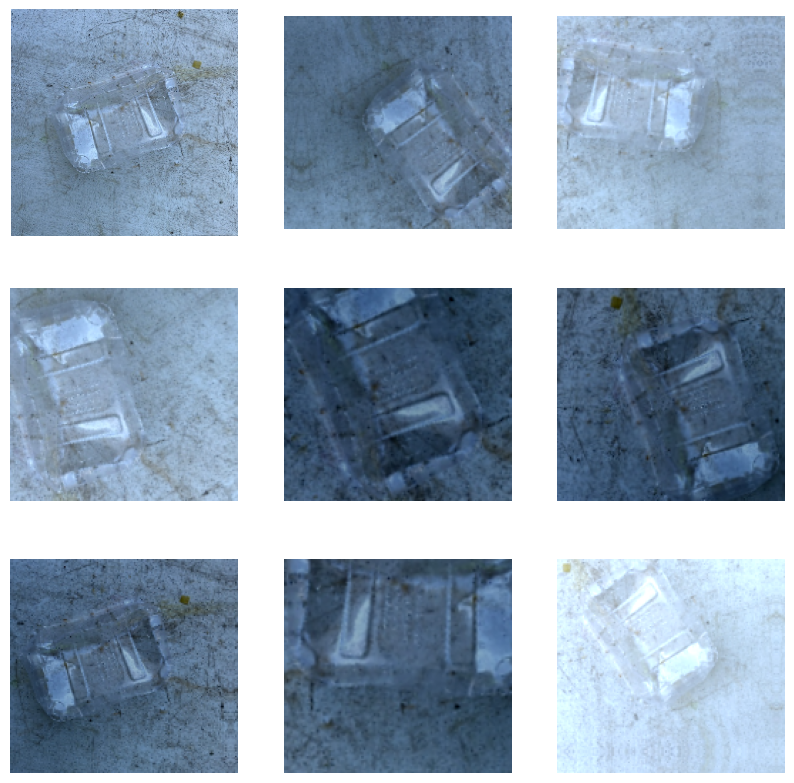

In [27]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]  # Select the first image in the batch

        # Apply augmentation multiple times to the same image
    augmented_images = [image]
    for _ in range(8):  # Create 8 augmented versions
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])

        # Display the original and augmented images
    for i in range(9):  # Display 9 images (1 original + 8 augmented)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Call the function to visualize data augmentation
visualize_dataset(dataset, class_names)

In [28]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.one_hot(label, num_classes)
    return image, label




In [29]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [53]:
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)

val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)

In [54]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


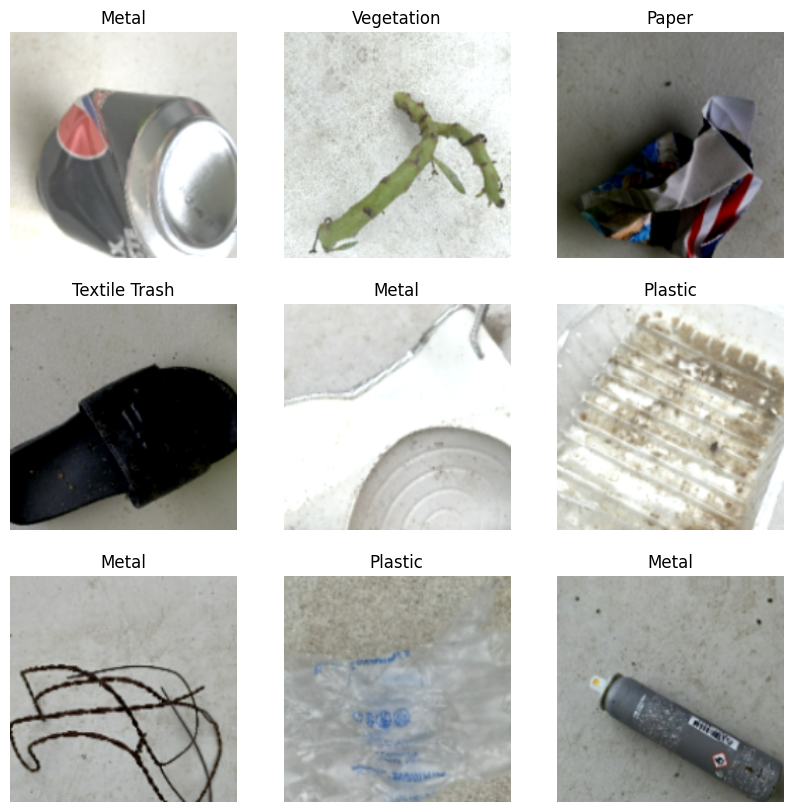

In [55]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            plt.imshow(img)
            label_idx = tf.argmax(labels[i]).numpy()  # Extract class index from one-hot label
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)

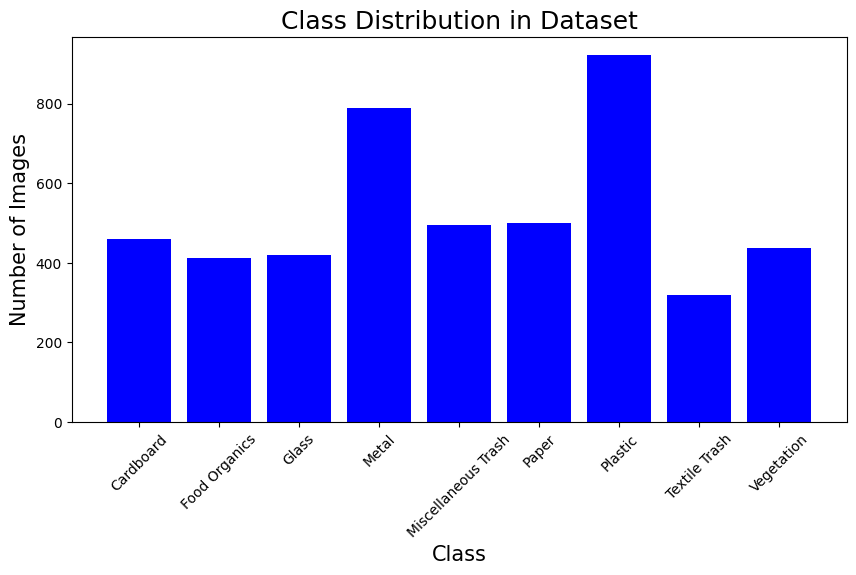

In [56]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [57]:


# Ensure eager execution is enabled
# tf.compat.v1.enable_eager_execution()

# Iterate over batches of the training dataset
train_labels = []

# Use .as_numpy_iterator() to convert the TensorFlow dataset to numpy
for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]  # Extract the labels (second element of the batch)

    # If labels are one-hot encoded, convert to class indices
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    train_labels.extend(labels)  # Add the labels to the list

# Convert the list of labels into a numpy array
train_labels = np.array(train_labels)

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print out class weights (for reference)
print("Class weights:", class_weights_dict)



Class weights: {0: np.float64(1.127371273712737), 1: np.float64(1.2244297277409861), 2: np.float64(1.2974658869395712), 3: np.float64(0.6591404238463062), 4: np.float64(1.0940170940170941), 5: np.float64(1.0475291155177842), 6: np.float64(0.5706447187928669), 7: np.float64(1.6656656656656657), 8: np.float64(1.2707140129820542)}


In [58]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model



# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",  # Monitor the validation loss
                               patience=3,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights when stopping
                               verbose=1)  # Print messages when stopping

# history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, callbacks=[early_stopping])



In [59]:
# Fine-tuning (optional)
base_model.trainable = True
for layer in base_model.layers[:5]:  # Freeze first 100 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train again on the small batch
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, )

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 156s 737ms/step - accuracy: 0.0937 - loss: 3.5420 - val_accuracy: 0.0852 - val_loss: 2.2471
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 728ms/step - accuracy: 0.1174 - loss: 3.1159 - val_accuracy: 0.0895 - val_loss: 2.2944
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 701ms/step - accuracy: 0.1769 - loss: 2.7277 - val_accuracy: 0.1264 - val_loss: 2.4444
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 687ms/step - accuracy: 0.2204 - loss: 2.4953 - val_accuracy: 0.1293 - val_loss: 2.7418
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 663ms/step - accuracy: 0.2596 - loss: 2.2438 - val_accuracy: 0.1790 - val_loss: 2.3485
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 94s 906ms/step - accuracy: 0.2838 - loss: 2.1093 - val_accuracy: 0.2060 - val_loss: 2.2808
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 725ms/step - accuracy: 0.3027 - loss: 2.0171 - val_accuracy: 0.2741 - val_loss: 2.0723
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 732ms/step - accuracy: 0.3499 - loss: 

In [60]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [61]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.49      0.45        70
           1       0.54      0.64      0.58        55
           2       0.30      0.12      0.17        57
           3       0.50      0.62      0.55       117
           4       0.33      0.38      0.35        74
           5       0.49      0.57      0.53        76
           6       0.63      0.23      0.34       136
           7       0.28      0.48      0.35        54
           8       0.65      0.77      0.70        65

    accuracy                           0.46       704
   macro avg       0.46      0.48      0.45       704
weighted avg       0.48      0.46      0.45       704



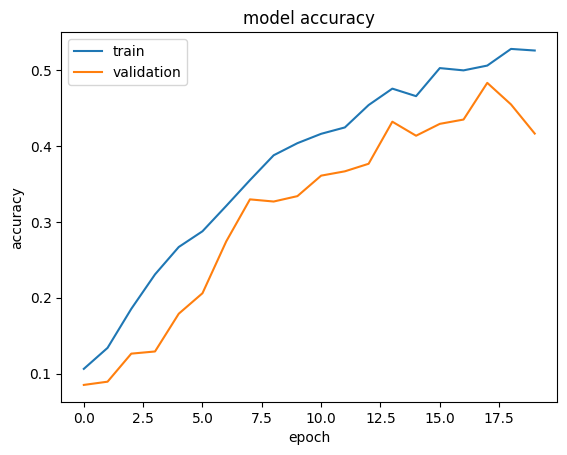

In [62]:
def plot_hist(history_fine_tune):
    plt.plot(history_fine_tune.history["accuracy"])
    plt.plot(history_fine_tune.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine_tune)

In [21]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.31      0.28        65
           1       0.30      0.61      0.41        51
           2       0.38      0.58      0.46        59
           3       0.56      0.52      0.54       111
           4       0.25      0.08      0.12        85
           5       0.33      0.18      0.23        73
           6       0.42      0.34      0.38       143
           7       0.30      0.48      0.37        54
           8       0.68      0.65      0.67        63

    accuracy                           0.40       704
   macro avg       0.39      0.42      0.38       704
weighted avg       0.40      0.40      0.38       704



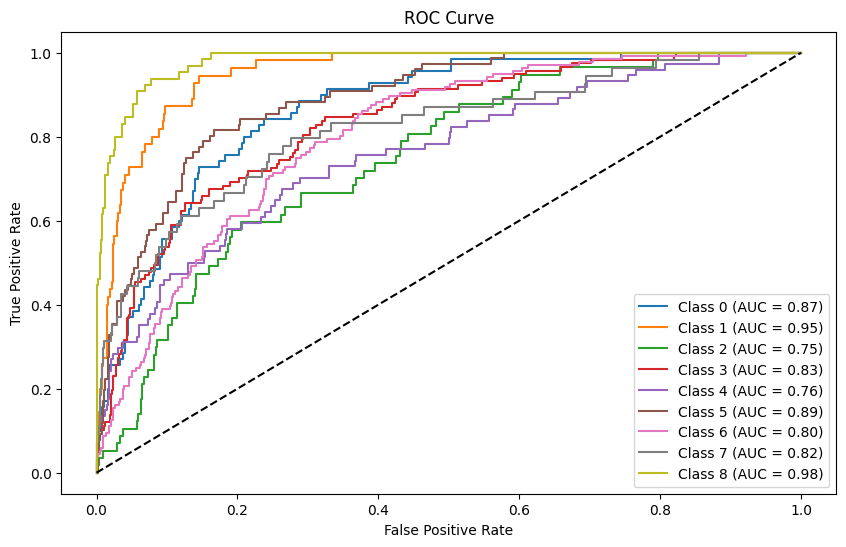

In [63]:

# Convert true labels to one-hot encoding
num_classes = 9  # Adjust to your number of classes
y_true_one_hot = to_categorical(y_true, num_classes)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

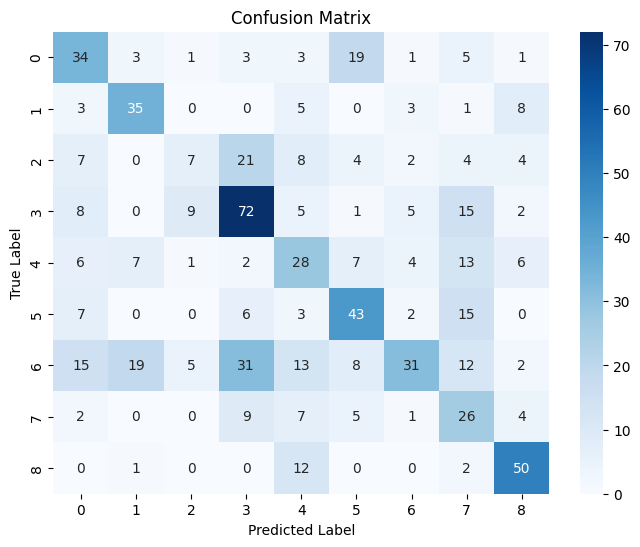

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [65]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 489ms/step - accuracy: 0.4162 - loss: 1.5708
Test Accuracy: 0.4333
Test Loss: 1.5617
